<h3> 🌌 Dataset Description</h3>

<p>You will have access to a training set and a test set. The training set contains the position and velocity measurements of the three bodies for different time steps. You sholid use this data to train your model and learn to propagate the trajectories of the objects. The test set contains an initial position and several time steps. Using your trained model, you sholid predict the positions of the three objects starting from the initial position. Additionally, you have access to a sample submission. This is an example of what your submission files sholid look like so that the system can accept them welwelelelelee.</p>

<h5>📁 Files</h5>
<ul>
  <li><code>X_train.csv</code> — training set (1,285,000 rows, 14 cols; 5000 trajectories × 257 timesteps)</li>
  <li><code>X_test.csv</code> — test set (1,041,621 rows, 8 cols; 4053 trajectories × 257 timesteps)</li>
  <li><code>sample_submission.csv</code> — example in the correct format (random predictions)</li>
</ul>

<h4>X_train Columns</h4>
<ul>
  <li><code>Id</code> — row index (use <code>traj_id = Id // 257</code>)</li>
  <li><code>t</code> — timestep</li>
  <li><code>x_1, y_1, v_x_1, v_y_1</code> — position/velocity of object 1</li>
  <li><code>x_2, y_2, v_x_2, v_y_2</code> — position/velocity of object 2</li>
  <li><code>x_3, y_3, v_x_3, v_y_3</code> — position/velocity of object 3</li>
</ul>

<h4>X_test Columns</h4>
<ul>
  <li><code>Id</code> — row id (257 rows per trajectory)</li>
  <li><code>t</code> — timestep</li>
  <li><code>x0_1, y0_1</code> — object 1 initial position (t=0)</li>
  <li><code>x0_2, y0_2</code> — object 2 initial position (t=0)</li>
  <li><code>x0_3, y0_3</code> — object 3 initial position (t=0)</li>
</ul>

<p><b>Note:</b> After a collision, remaining rows in that trajectory are zero-padded (features become zero; <code>t</code> may be 0). Exclude these rows when training/validating.</p>



<h3>📚 Imports</h3>

In [18]:
import matplotlib.pyplot as plt                        # Library for plotting graphs and visualizations
import numpy as np                                     # Library for numerical computing (arrays, math functions)
import pandas as pd                                    # Library for handling datasets (tables, CSVs, DataFrames)
from sklearn.metrics import mean_squared_error , root_mean_squared_error  # Function to evaluate model performance using MSE
from sklearn.model_selection import train_test_split   # Utility to split dataset into training and testing sets
from sklearn.preprocessing import StandardScaler       # Tool to normalize/standardize features
from sklearn.preprocessing import PolynomialFeatures   # Generates polynomial features for non-linear regression
from sklearn.pipeline import make_pipeline             # Builds pipelines that chain preprocessing + model steps
from sklearn.linear_model import LinearRegression      # Ordinary least squares linear regression model
from sklearn.linear_model import Ridge, RidgeCV        # Ridge regression (L2 regularization) and Ridge with cross-validation
from sklearn.compose import ColumnTransformer          # Apply transformations to specific columns of the dataset
from sklearn.preprocessing import FunctionTransformer  # Apply custom functions to transform data
from sklearn.neighbors import KNeighborsRegressor
import math
import time                                            # Python built-in library to measure execution time
import seaborn as sns                                  #Statistical data visualization                           
import os

<h3>📂 Load Data</h3>

In [19]:
data = pd.read_csv("../../data/X_train.csv")
test = pd.read_csv("../../data/X_test.csv")

data.head()  # Display the first few rows of the dataset to understand its structure
data.columns  # List all column names to identify features and target variable

Index(['t', 'x_1', 'y_1', 'v_x_1', 'v_y_1', 'x_2', 'y_2', 'v_x_2', 'v_y_2',
       'x_3', 'y_3', 'v_x_3', 'v_y_3', 'Id'],
      dtype='object')

<h2>Task 1 - Setting the Baseline</h2>
<h3>Task 1.1 - Data Preparation and Validation Pipeline</h3>

<h3>Exploration + grafic Functions (insightful)</h3>

,Metric,Value
0,Rows,1285000
1,Cols,22
2,Number of trajectories with colisions,5000
3,Steps per trajectory (min),257
4,Steps per trajectory (max),257
5,Steps per trajectory (mean),257.00
6,% Colision rows rows,15.19%
7,"Range of time [min,max]","[0.0, 10.0]"


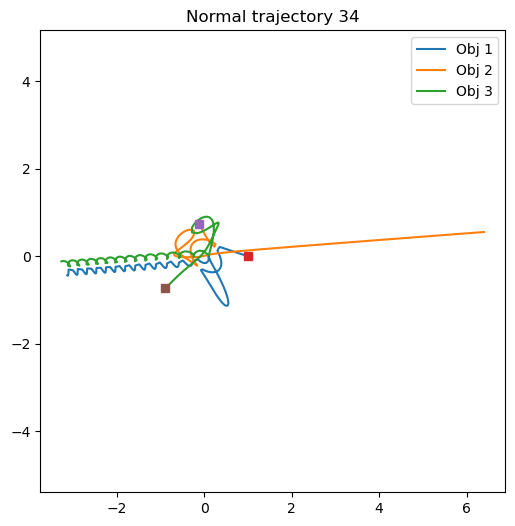

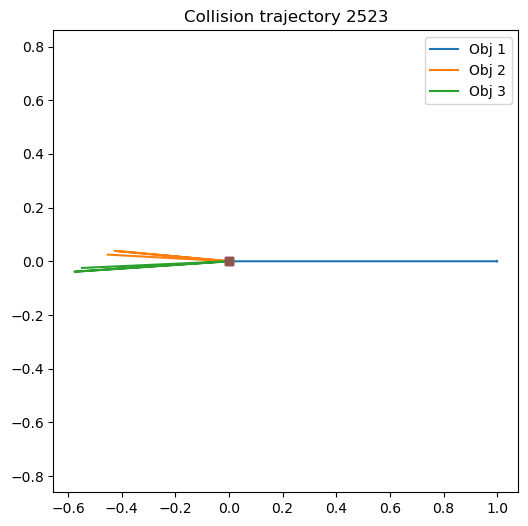

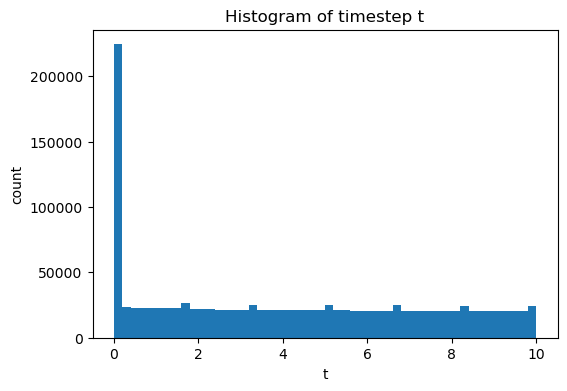

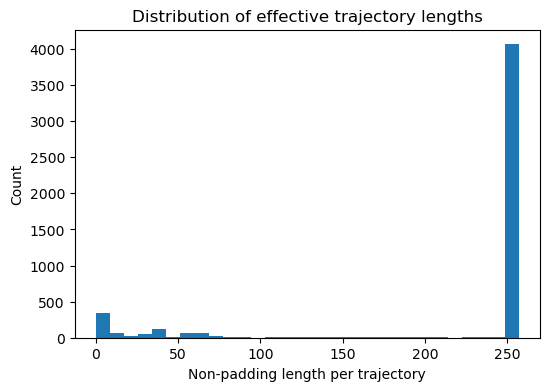

Total of lines with padding and colisions: 243379
Total of trajectories with padding and colisions: 947
Total of lines without padding and colisions: 1041621
Total of trajectories without padding and colisions: 4053
Train: (729109, 7) (729109, 6)
Val:   (155999, 7) (155999, 6)
Test:  (156513, 7) (156513, 6)


In [20]:
##### Data visualization #####

#Creates a unique identifier for each trajectory
#Essential to group lines by trajectory (to exclude collisions and make correct division)
def add_traj_id(df, steps_per_traj= 257):
    df=df.copy() # Avoid modifying the original DataFrame
    df["traj_id"] = (df["Id"] // steps_per_traj) #Each trajectory has 257 steps, e.g index 0-256 -> traj_id 0, index 257-514 -> traj_id 1, etc.
    return df

#Identifies all the lines that have a colision with True
#Essential for filtering colisions and the trajectories with colisions 
def mark_padding(df):
    df=df.copy()
    feat_cols = [
        'x_1','y_1','v_x_1','v_y_1',
        'x_2','y_2','v_x_2','v_y_2',
        'x_3','y_3','v_x_3','v_y_3'
    ]
    df["is_padding"] = (df[feat_cols].abs().sum(axis=1)==0) #If all feature columns are zero, mark as colision (True)
    return df

#Identifies the initial position of each trajectorie and puts with x0_* and y0_*
#Essential to use the starting positions as static features.
def add_initial_positions(df):
    df=df.copy()
    first =df.loc[df.groupby("traj_id")["t"].idxmin(),  # Get the first row (t=0) for each trajectory
        ["traj_id","x_1","y_1","x_2","y_2","x_3","y_3"]].rename(columns={
        "x_1":"x0_1","y_1":"y0_1",
        "x_2":"x0_2","y_2":"y0_2",
        "x_3":"x0_3","y_3":"y0_3"
    })
    #Get the positions x,y for t=0 and rename the columns to x0_*, y0_* for each object
    df= df.merge(first, on="traj_id", how="left")
    return df

#Pipeline
def preprocess_train(df, steps_per_traj=257):
    df = add_traj_id(df, steps_per_traj=steps_per_traj)
    df = mark_padding(df)
    df = add_initial_positions(df)
    return df #Final dataset with traj_id, is padding, x0_*, y0_*, x_*, y_*, v_x_*, v_y_*

#Dataset visualization
#Important for exploring and documenting the database
def dataset_overview(df):
    n_rows, n_cols = df.shape #Number of lines and columns
    n_traj = df["traj_id"].nunique() #Number of unique trajectories
    steps_per_traj = df.groupby("traj_id")["t"].size() #Number of steps per trajectory
    colision_rows = 100 * df["is_padding"].mean()  #Percentage of padding rows

    info = pd.DataFrame({
        "Metric": [
            "Rows", 
            "Cols",
            "Number of trajectories with colisions",
            "Steps per trajectory (min)",
            "Steps per trajectory (max)",
            "Steps per trajectory (mean)",
            "% Colision rows rows",
            "Range of time [min,max]"
        ],
        "Value": [
            n_rows, 
            n_cols,
            n_traj,
            steps_per_traj.min(),
            steps_per_traj.max(),
            f"{steps_per_traj.mean():.2f}",
            f"{colision_rows:.2f}%",
            f"[{df['t'].min()}, {df['t'].max()}]"
        ]
    })
    return info

#Finds the trajectories that were classified has True in padding
#Important for insight into dynamics and collisions.
def find_collision_traj(df):
    has_pad = df.groupby("traj_id")["is_padding"].any() #Check which trajectories have any padding (True)
    colision_id = has_pad[has_pad].index #Get the traj_id of those trajectories
    return int(np.random.choice(colision_id)) if len(colision_id) > 0 else None #Choses one padding trajectory randomly 

#Histogram of non_paddings trajectories
#Important for understanding the effective trajectory lengths 
def plot_hist_nonpadding_lengths(df): 
    g = df.groupby("traj_id") #Join all the lines for the same trajectory
    lengths = (g["is_padding"].apply(lambda s: (~s).sum())).values #Count the number of non-padding lines per trajectory
    plt.figure(figsize=(6,4))
    plt.hist(lengths, bins=30)
    plt.xlabel("Non-padding length per trajectory")
    plt.ylabel("Count")
    plt.title("Distribution of effective trajectory lengths")
    plt.show()
 
#Histogram os a random trajectory
#Important for visualizing the movement patterns of objects in a trajectory
def plot_one_trajectory(df, traj_id=None, title_prefix="Trajectory"):
    if traj_id is None:
        traj_id = np.random.choice(df["traj_id"].unique()) #Choose a random trajectory if none is provided

    d = df.loc[df["traj_id"] == traj_id].sort_values("t") #Get all lines for the selected trajectory and sort by time
    plt.figure(figsize=(6,6))
    plt.plot(d["x_1"], d["y_1"], label="Obj 1")
    plt.plot(d["x_2"], d["y_2"], label="Obj 2")
    plt.plot(d["x_3"], d["y_3"], label="Obj 3")
    plt.plot(d["x_1"].iloc[0], d["y_1"].iloc[0], 's')
    plt.plot(d["x_2"].iloc[0], d["y_2"].iloc[0], 's')
    plt.plot(d["x_3"].iloc[0], d["y_3"].iloc[0], 's')
    plt.axis('equal')
    plt.legend()
    plt.title(f"{title_prefix} {traj_id}")
    plt.show()

#Plots 
def plot_t_hist(df):
    plt.figure(figsize=(6,4))
    plt.hist(df["t"], bins=50)
    plt.xlabel("t")
    plt.ylabel("count")
    plt.title("Histogram of timestep t")
    plt.show()

#Show the results
train = preprocess_train(data, steps_per_traj=257)
overview = dataset_overview(train)
display(overview)
plot_one_trajectory(train, traj_id=None, title_prefix="Normal trajectory") #Plot a random trajectory
col_traj = find_collision_traj(train)
if col_traj is not None:
    plot_one_trajectory(train, traj_id=col_traj, title_prefix="Collision trajectory") #Plot a random collision trajectory
else:
    print("No collision trajectories found (no padding)")

plot_t_hist(train)
plot_hist_nonpadding_lengths(train)

##### Data splitting #####

#Definition of features and targets
FEATURES = ["t","x0_1","y0_1","x0_2","y0_2","x0_3","y0_3"]
TARGETS  = ["x_1","y_1","x_2","y_2","x_3","y_3"]

#Defining split function in 70% train, 15% test and 15%validation
def make_train_val_test_split( 
    dataset: pd.DataFrame,
    features: list = FEATURES,
    targets: list  = TARGETS,
    train_size: float = 0.7,
    val_size: float = 0.15,
    test_size: float = 0.15,
    random_state: int = 42 #For reproducibility of the random split
):
    #Making sure that the sum of the fractions is 1
    assert abs(train_size + val_size + test_size - 1.0) < 1e-8, "Sum of fractions is 1"
    
    #Removing all the lines with padding 
    traj_with_padding = dataset.loc[dataset["is_padding"], "traj_id"].unique()
    
    #Removing colisions
    collision_mask = (dataset["t"] == 0) & \
                     (dataset[["x_1","y_1","x_2","y_2","x_3","y_3"]] == 0).all(axis=1)
    
    traj_with_collision = dataset.loc[collision_mask, "traj_id"].unique()
    
    lines_with_pad_or_collision = dataset["traj_id"].isin(traj_with_padding) | dataset["traj_id"].isin(traj_with_collision)

    print("Total of lines with padding and colisions:", lines_with_pad_or_collision.sum())
    print("Total of trajectories with padding and colisions:", dataset.loc[lines_with_pad_or_collision, 'traj_id'].nunique())
    
    dataset= dataset[~dataset["traj_id"].isin(traj_with_padding) & 
                        ~dataset["traj_id"].isin(traj_with_collision)]
    
    print("Total of lines without padding and colisions:", dataset.shape[0])
    print("Total of trajectories without padding and colisions:", dataset['traj_id'].nunique())

    #Making sure that the trajectories are unique 
    unique_traj = np.array(dataset["traj_id"].unique()) #Get unique trajectory IDs
    np.random.seed(random_state) #Set random seed for reproducibility
    np.random.shuffle(unique_traj) #Shuffle the trajectory IDs randomly

    #Total number of unique trajectories and dividing fot each split according to the fractions and the total number of unique trajectories
    n_total = len(unique_traj) 
    n_train = int(train_size * n_total)
    n_val   = int(val_size * n_total)
    n_test = n_total - n_train - n_val

    #Getting the trajectory IDs for each split in an indenpendent manner
    tr_ids = unique_traj[:n_train]
    va_ids = unique_traj[n_train:n_train+n_val]
    te_ids = unique_traj[n_train+n_val:]
    
    #Creating a dataset with the trajectory IDs per split
    tr = dataset[dataset["traj_id"].isin(tr_ids)].copy() 
    va = dataset[dataset["traj_id"].isin(va_ids)].copy()
    te = dataset[dataset["traj_id"].isin(te_ids)].copy()
    
    #Extracting X and Y arrays for each ID of each split 
    X_tr, y_tr = tr[features].values, tr[targets].values
    X_va, y_va = va[features].values, va[targets].values
    X_te, y_te = te[features].values, te[targets].values

    return X_tr, y_tr, X_va, y_va, X_te, y_te, tr, va, te

#Executing split
X_tr, y_tr, X_va, y_va, X_te, y_te, tr_df, va_df, te_df = make_train_val_test_split(train)

print("Train:", X_tr.shape, y_tr.shape)
print("Val:  ", X_va.shape, y_va.shape)
print("Test: ", X_te.shape, y_te.shape)

<h3>Task 1.2 - Learn the baseline model</h3>

Baseline RMSE (validation split): 1.4159063657148816


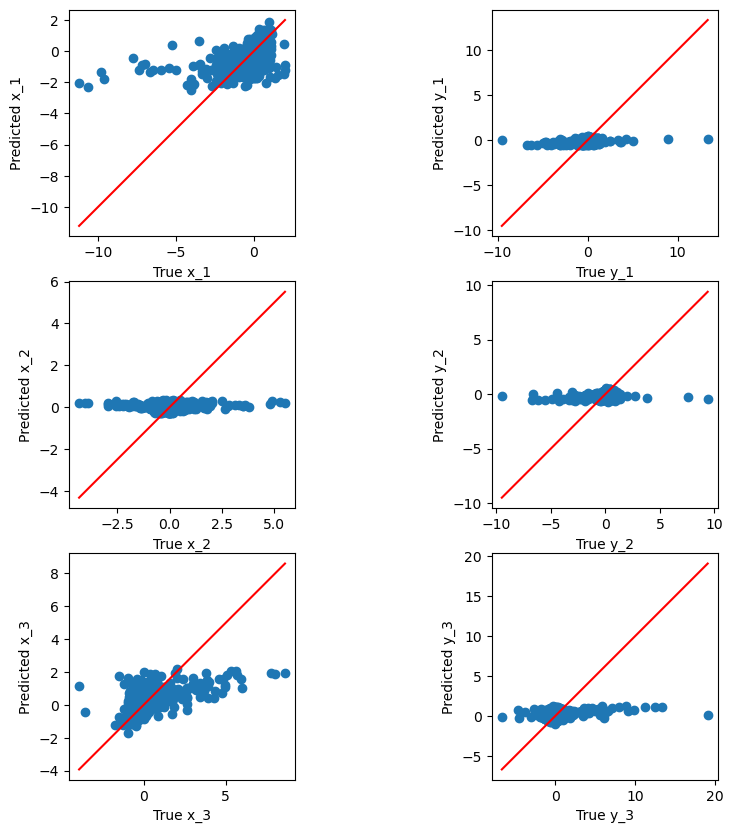

Saved submission file: baseline-model.csv


In [35]:
#Pipeline: StandardScaler for normalizing the values and doing the linear regression
baseline = make_pipeline(StandardScaler(with_mean=True), LinearRegression())
baseline.fit(X_tr, y_tr)  #Training the model with X,Y training
y_hat = baseline.predict(X_va)  #y_hat is the prevision for the validation set

#Doing the mean squared error between the prevision (y_hat) and the real values(y_va)
rmse = mean_squared_error(y_va, y_hat) 
rmse_baseline = np.sqrt(mean_squared_error(y_va, y_hat))
print("Baseline RMSE (validation split):", rmse_baseline)

#Plot y_^y
def plot_y_yhat(y_test,y_pred, plot_title = "plot"):
    labels = ['x_1','y_1','x_2','y_2','x_3','y_3']
    save_dir = "../outputs/pdf"
    os.makedirs(save_dir, exist_ok=True)
    MAX = 500 #Maximum number of points to plot for clarity
    if len(y_test) > MAX: 
        idx = np.random.choice(len(y_test),MAX, replace=False) #Randomly choose MAX indices to plot
    else:
        idx = np.arange(len(y_test)) #Use all indices if less than MAX
    plt.figure(figsize=(10,10))
    for i in range(6): #For each of the 6 target variables
        x0 = np.min(y_test[idx,i])
        x1 = np.max(y_test[idx,i])
        plt.subplot(3,2,i+1)
        plt.scatter(y_test[idx,i],y_pred[idx,i])
        plt.xlabel('True '+labels[i])
        plt.ylabel('Predicted '+labels[i])
        plt.plot([x0,x1],[x0,x1],color='red')
        plt.axis('square')
    save_path = os.path.join(save_dir, plot_title + '.pdf')
    plt.savefig(save_path)
    plt.show()
    

plot_y_yhat(y_va, y_hat, plot_title="baseline_validation")

#Preparing the dataset for training
full = train[~train["is_padding"]].copy()
X_full = full[FEATURES].values
y_full = full[TARGETS].values

#Baseline model
baseline_full = make_pipeline(StandardScaler(with_mean=True), LinearRegression())
baseline_full.fit(X_full, y_full)

#Preparing test
X_test = test[["t","x0_1","y0_1","x0_2","y0_2","x0_3","y0_3"]].values
pred = baseline_full.predict(X_test)

#Construct the submission
submission = pd.DataFrame({
    "Id": test["Id"].astype(np.int64),
    "x_1": pred[:,0], "y_1": pred[:,1],
    "x_2": pred[:,2], "y_2": pred[:,3],
    "x_3": pred[:,4], "y_3": pred[:,5],
})
submission.to_csv("../outputs/csv/baseline-model.csv", index=False)
print("Saved submission file: baseline-model.csv") 

<h3>Task 2 -  Nonlinear models on the data — the Polynomial model</h3>

<h3>Task 2.1 - Development</h3>

 Linear Regression
degree= 1 | feats=    7 | time=  0.01s | RMSE= 1.4162
degree= 2 | feats=   35 | time=  0.02s | RMSE= 1.3778
degree= 3 | feats=  119 | time=  0.05s | RMSE= 1.3336
degree= 4 | feats=  329 | time=  0.17s | RMSE= 1.2997
degree= 5 | feats=  791 | time=  0.44s | RMSE= 1.2929
[skip] grau 6 → 1715 features (limite 1500)
[skip] grau 7 → 3431 features (limite 1500)
 Best RMSE (Linear): 1.2929166109111911 

 RidgeCV (L2 regularization)
degree= 1 | feats=    7 | time=  0.02s | RMSE= 1.4162
degree= 2 | feats=   35 | time=  0.04s | RMSE= 1.3779
degree= 3 | feats=  119 | time=  0.14s | RMSE= 1.3336
degree= 4 | feats=  329 | time=  0.43s | RMSE= 1.2975
degree= 5 | feats=  791 | time=  1.29s | RMSE= 1.2638
[skip] grau 6 → 1715 features (limite 1500)
[skip] grau 7 → 3431 features (limite 1500)
 Best RMSE (RidgeCV): 1.2637504701353894
Linear summary:
    degree  n_features  fit_time_s  rmse_val
0       1           7    0.005576  1.416203
1       2          35    0.017474  1.377825
2   

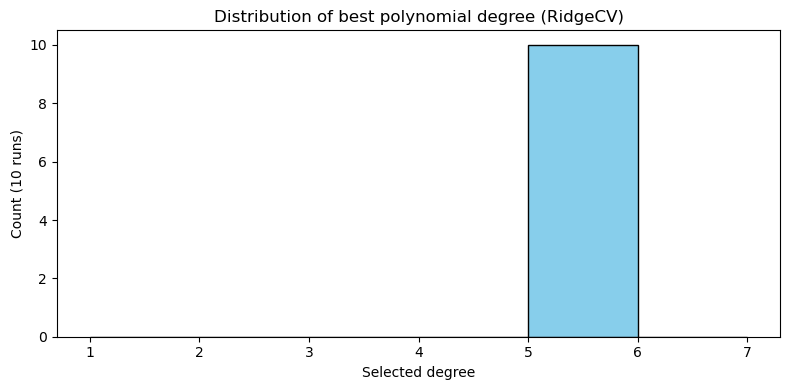

Final chosen degree: 5


In [22]:
#Define the regressor by Ridge regularization to use in the pipeline
def pick_regressor(use_ridge=False, ridge_alphas=(0.01, 0.1, 1.0, 10.0, 100.0)): #Defining the value of lambda for Ridge regularization(penalty term)
    if use_ridge:
        alphas_array = np.array(ridge_alphas)  #If ridge is used, convert the alphas to a numpy array
        regressor = RidgeCV(alphas=alphas_array) #The model is a linear regression with Ridge
    else:
        regressor = LinearRegression() #If ridge is not used, the model is a simple linear regression
    return regressor

#Creates a validation function for polynomial regression models to choose the best degree and model
def validate_polynomial(
    X_train, y_train, X_val, y_val, #Split data from the make_train_val_test_split function
    degrees=range(1, 8),        
    max_features=1500,          
    sample_frac=0.03,         
    random_state=42,
    use_ridge=False,
    ridge_alphas=(0.01, 0.1, 1.0, 10.0, 100.0),
    verbose=True #Print progress
):
    
    rng = np.random.RandomState(random_state) 
    
    #Creating small training subset for faster validation
    n = len(X_train)
    k = max(1, int(round(sample_frac * n))) #Small number of samples to use from the training set
    idx = rng.choice(n, k, replace=False) #Randomly choose k indices from the small number of samples from training set
    #Train sets only contain the index from k samples
    X_sub = X_train[idx].astype(np.float32, copy=False) 
    y_sub = y_train[idx].astype(np.float32, copy=False)
    
    Xv = X_val.astype(np.float32, copy=False)
    yv = y_val.astype(np.float32, copy=False)

    best_rmse = np.inf #Initialize best RMSE to infinity (any model will be better)
    best_model = None #Keeps the variable for the best model found
    logs = [] #To store logs of each degree tested
    n_in = X_sub.shape[1]

    #Model training
    for d in degrees:
        probe = PolynomialFeatures(degree=d, include_bias=False) #See how many features the polynomial of degree d will generate (without training)
        probe.fit(np.zeros((1, n_in), dtype=np.float32)) 
        n_feats = int(probe.n_output_features_) 

        if max_features is not None and n_feats > max_features: 
            if verbose:
                print(f"[skip] grau {d} → {n_feats} features (limite {max_features})") #Skip this degree if it generates more features than the max_features defined 
            logs.append((d, n_feats, np.nan, np.nan)) 
            continue

        model = pick_regressor(use_ridge=use_ridge, ridge_alphas=ridge_alphas) #Choose the model (Ridge or Linear Regression)
        pipe = make_pipeline(
            PolynomialFeatures(degree=d, include_bias=False), #Expands the features to polynomial features of degree d
            StandardScaler(with_mean=True), #Standardizes the features by the mean
            model
        )

        t0 = time.time() #Measure the time taken to fit the model
        pipe.fit(X_sub, y_sub) #Fit the model with the small training set
        fit_time = time.time() - t0 #Time taken to fit the model

        #Model validation
        pred = pipe.predict(Xv) #Predict the validation set
        rmse = float(np.sqrt(mean_squared_error(yv, pred))) #Calculate the RMSE for the validation set

        logs.append((d, n_feats, fit_time, rmse))
        if verbose:
            print(f"degree={d:>2} | feats={n_feats:>5} | time={fit_time:6.2f}s | RMSE={rmse:7.4f}")

        if rmse < best_rmse: #If the RMSE of this model is better than the best found so far, update best_rmse and best_model
            best_rmse = rmse
            best_model = pipe

    return best_model, best_rmse, logs

#Run a simple validation trial in linear regression and ridge regression
DEGREES=range(1, 8)
MAX_FEATURES=1500
SAMPLE_FRAC=0.03

print(" Linear Regression")
best_lin, rmse_lin, logs_lin = validate_polynomial(
    X_tr, y_tr, X_va, y_va,
    degrees=DEGREES,
    max_features=MAX_FEATURES,
    sample_frac=SAMPLE_FRAC,
    random_state=42,
    use_ridge=False,
    verbose=True
)
print(" Best RMSE (Linear):", rmse_lin, "\n")

print(" RidgeCV (L2 regularization)")
best_ridge, rmse_ridge, logs_ridge = validate_polynomial(
    X_tr, y_tr, X_va, y_va,
    degrees=DEGREES,
    max_features=MAX_FEATURES,
    sample_frac=SAMPLE_FRAC,
    random_state=42,
    use_ridge=True,
    ridge_alphas=(0.01, 0.1, 1.0, 10.0, 100.0),
    verbose=True
)
print(" Best RMSE (RidgeCV):", rmse_ridge)

#Function to convert logs to a DataFrame for better visualization
def logs_to_df(logs):
    return pd.DataFrame(logs, columns=["degree","n_features","fit_time_s","rmse_val"])

df_lin   = logs_to_df(logs_lin)
df_ridge = logs_to_df(logs_ridge)

print("Linear summary:\n", df_lin)
print("\nRidgeCV summary:\n", df_ridge)

#Choosing the best degree by running 10 times with different training subsets
best_degrees = []
for seed in range(1, 11): #Run 10 times with different random seeds to see the stability of the chosen degree
    mdl, rmse, logs = validate_polynomial(
        X_tr, y_tr, X_va, y_va,
        degrees=DEGREES,
        max_features=MAX_FEATURES,
        sample_frac=0.05,     
        random_state=seed,
        use_ridge=True,
        ridge_alphas=(0.01, 0.1, 1.0, 10.0, 100.0),
        verbose=False
    )
    df = logs_to_df(logs).dropna(subset=["rmse_val"])
    best_deg = int(df.loc[df["rmse_val"].idxmin(), "degree"])
    best_degrees.append(best_deg)

print("Best degrees across 10 runs:", best_degrees)

plt.figure(figsize=(8, 4))
plt.hist(best_degrees, bins=np.arange(1, 8, 1), edgecolor="black", color="skyblue")
plt.xlabel("Selected degree")
plt.ylabel("Count (10 runs)")
plt.title("Distribution of best polynomial degree (RidgeCV)")
plt.tight_layout()
plt.show()

#Chosing the final degree by majority vote
from collections import Counter
final_degree = Counter(best_degrees).most_common(1)[0][0]
print("Final chosen degree:", final_degree)

<h3>Task 2.2 - compare with baseline and submit</h3>

Chosen model: Pipeline(steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=5, include_bias=False)),
                ('standardscaler', StandardScaler()),
                ('ridgecv',
                 RidgeCV(alphas=array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])))])
Polynomial RMSE (validation): 1.26375059574697


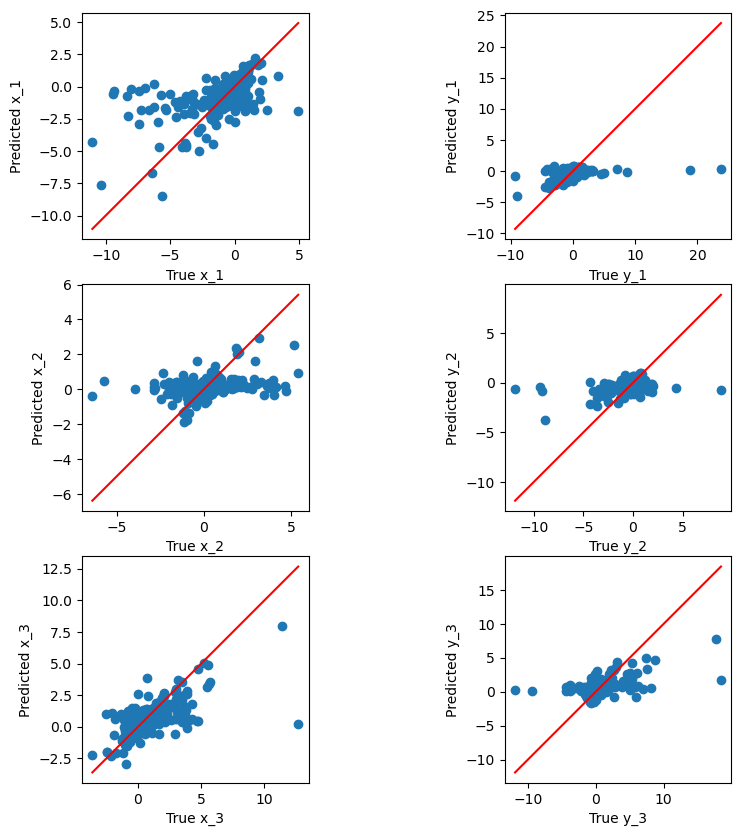

In [38]:
# entre Linear e Ridge, fica o melhor
save_dir = "../outputs/pdf"
os.makedirs(save_dir, exist_ok=True)
chosen_model = best_ridge if rmse_ridge <= rmse_lin else best_lin
print("Chosen model:", chosen_model)

y_va_pred = chosen_model.predict(X_va)
rmse_poly = float(np.sqrt(mean_squared_error(y_va, y_va_pred)))
print("Polynomial RMSE (validation):", rmse_poly)

# gráfico y–ŷ (mesma função que já usaste na Task 1)
_ = plot_y_yhat(y_va, y_va_pred, plot_title="poly_validation")

In [33]:
#Preparing the final dataset to train the final model
full = train[~train["is_padding"]].copy()
X_full = full[FEATURES].values
y_full = full[TARGETS].values

#Train on the maximum possible data with the chosen model and the best degree
is_ridge = isinstance(chosen_model.named_steps[list(chosen_model.named_steps.keys())[-1]], RidgeCV)
reg_final = pick_regressor(use_ridge=is_ridge, ridge_alphas=(0.01, 0.1, 1.0, 10.0, 100.0))

#Rebuild pipeline with the final DEGREE and the chosen regressor type
final_model = make_pipeline(
    PolynomialFeatures(degree=int(final_degree), include_bias=False),
    StandardScaler(with_mean=True),
    reg_final
)
final_model.fit(X_full, y_full)

#Test prediction
X_test_arr = test[["t","x0_1","y0_1","x0_2","y0_2","x0_3","y0_3"]].values
pred = final_model.predict(X_test_arr)

#Saving submission in required format
polysub = pd.DataFrame({
    "Id": test["Id"].astype(np.int64),
    "x_1": pred[:,0], "y_1": pred[:,1],
    "x_2": pred[:,2], "y_2": pred[:,3],
    "x_3": pred[:,4], "y_3": pred[:,5],
})
polysub.to_csv("../assigment#1/outputs/polynomial_submission.csv", index=False)
print(f"Saved: polynomial_submission.csv (degree={final_degree}, ridge={is_ridge})")

Saved: polynomial_submission.csv (degree=5, ridge=True)


<h2> Task 3 -  Feature Engineering </h2>

<h3>Task 3.1 - Removing variables</h3>

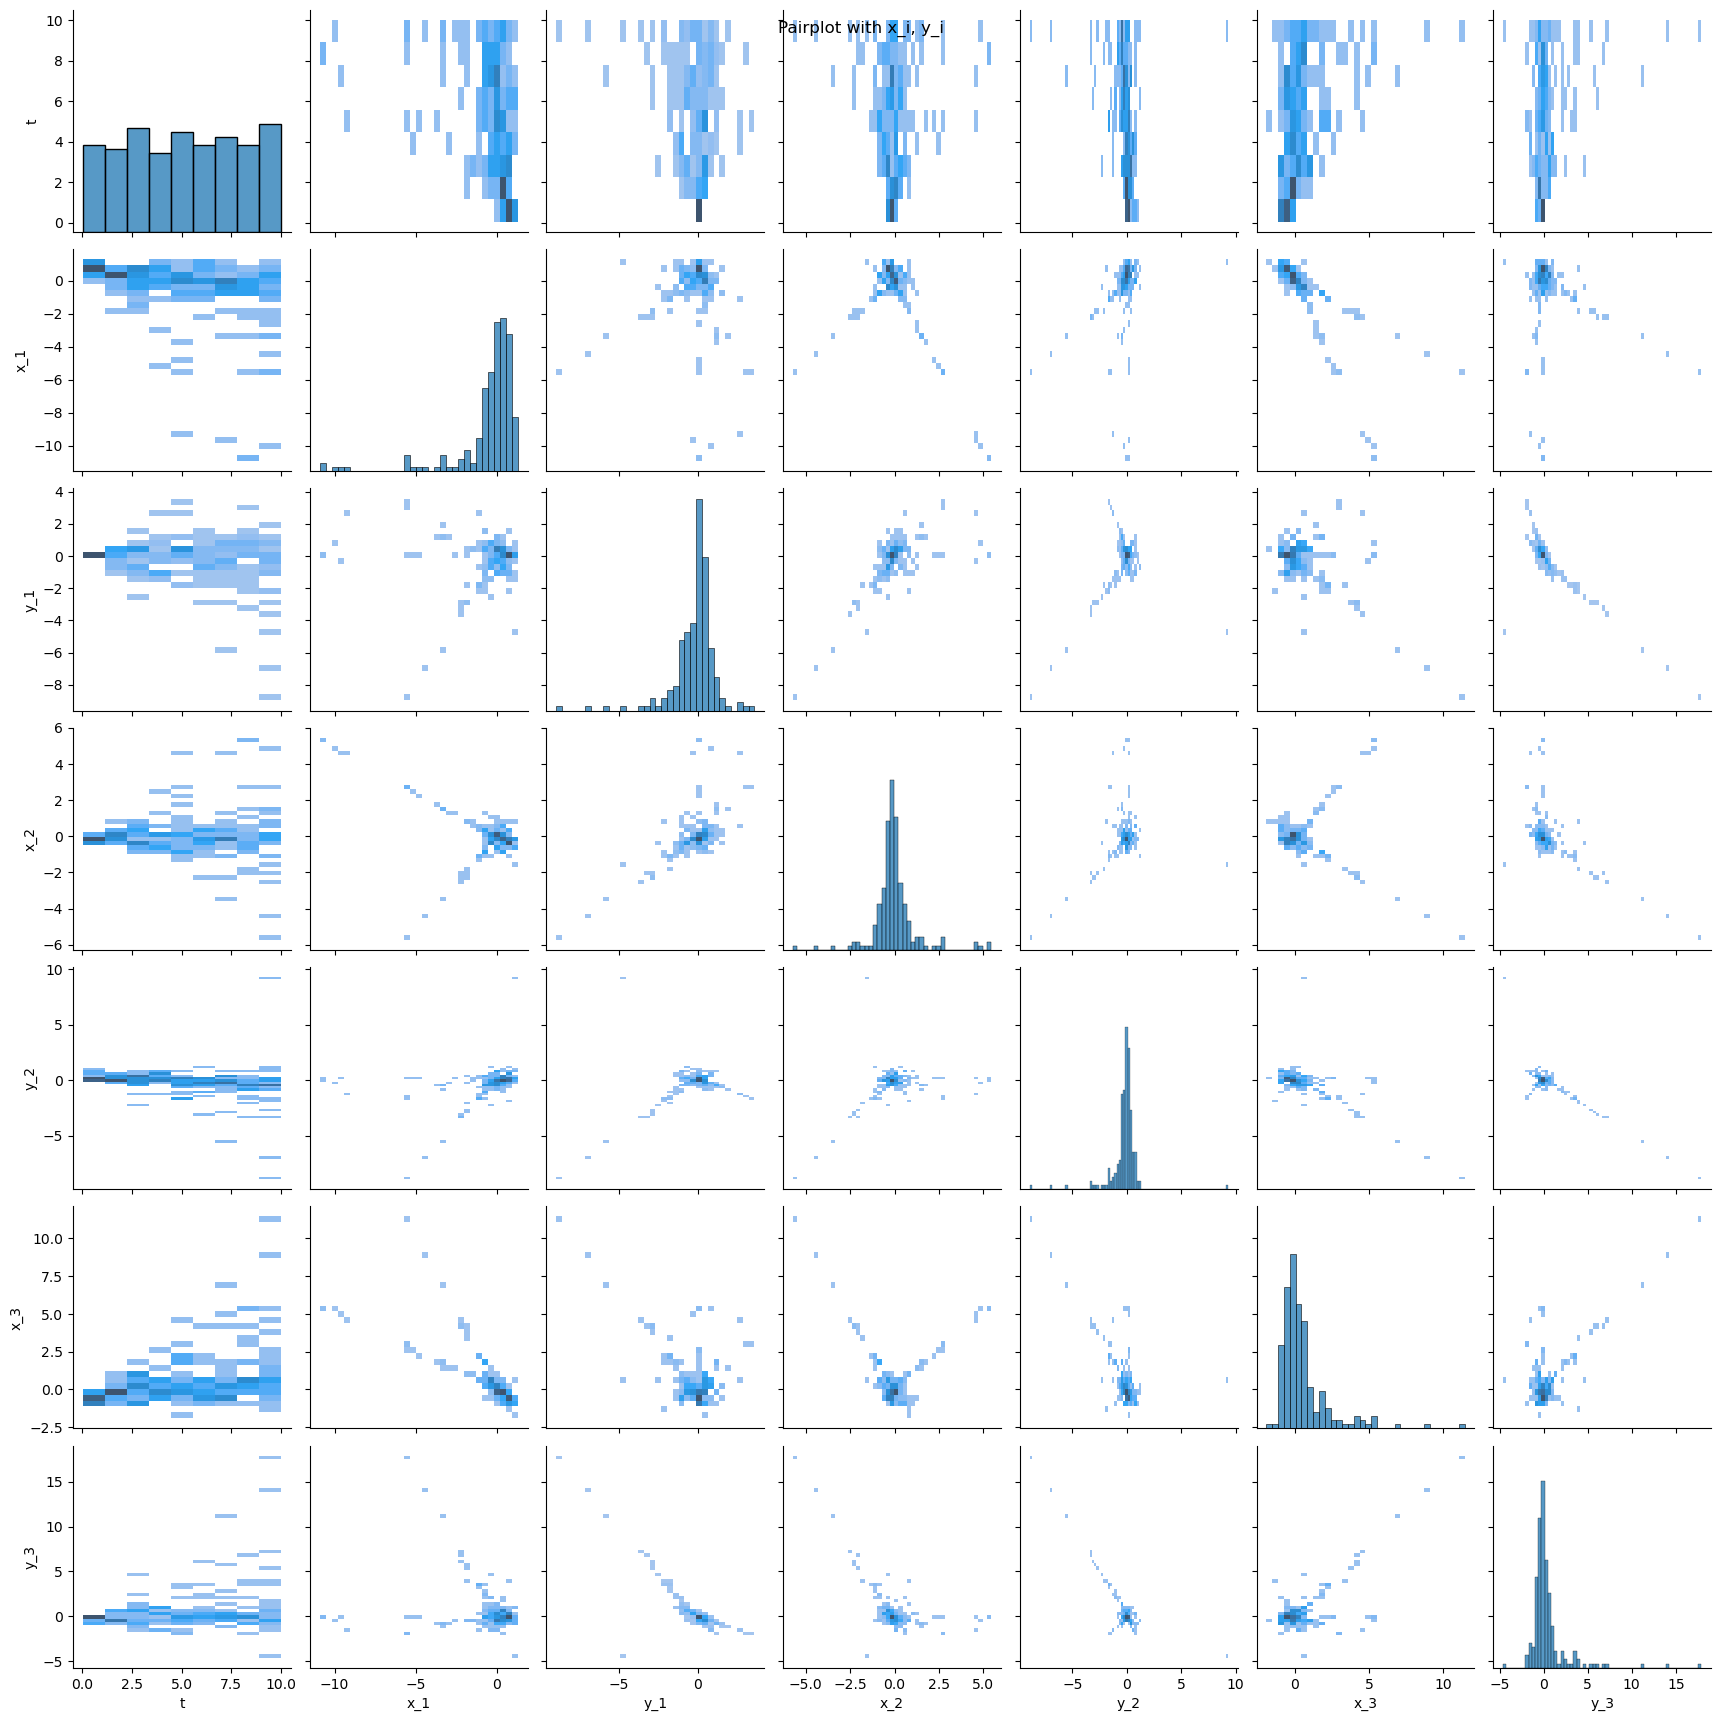

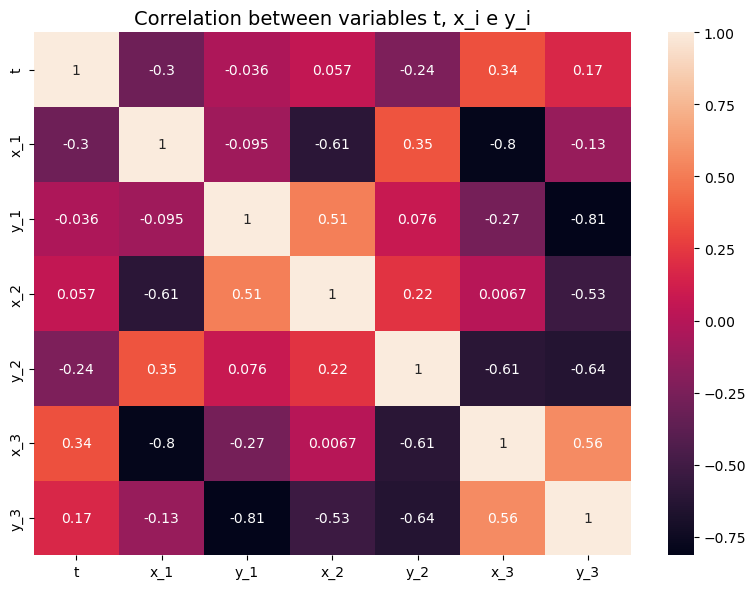

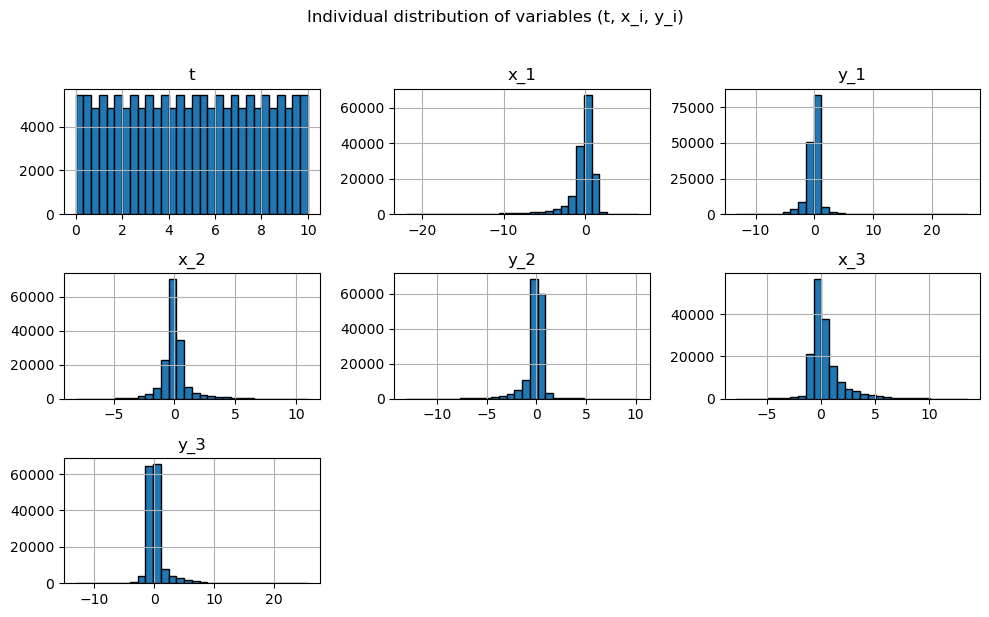

Correlations by order:

t    t      1.000000
y_1  y_3   -0.814632
x_1  x_3   -0.798063
y_2  y_3   -0.640459
     x_3   -0.610174
x_1  x_2   -0.607937
x_3  y_3    0.563446
x_2  y_3   -0.525322
y_1  x_2    0.514985
x_1  y_2    0.351193
t    x_3    0.339845
     x_1   -0.304254
y_1  x_3   -0.270725
t    y_2   -0.237880
x_2  y_2    0.221190
t    y_3    0.166106
x_1  y_3   -0.130825
     y_1   -0.095367
y_1  y_2    0.076320
t    x_2    0.057114
     y_1   -0.036011
x_2  x_3    0.006737
dtype: float64
 Baseline RMSE (WITHOUT REMOVAL): 1.261110479473858
Removed t → 6 features left
Removed x0_1 → 6 features left
Removed y0_1 → 6 features left
Removed x0_2 → 6 features left
Removed y0_2 → 6 features left
Removed x0_3 → 6 features left
Removed y0_3 → 6 features left
Removed      t  RMSE = 1.4587842632518775


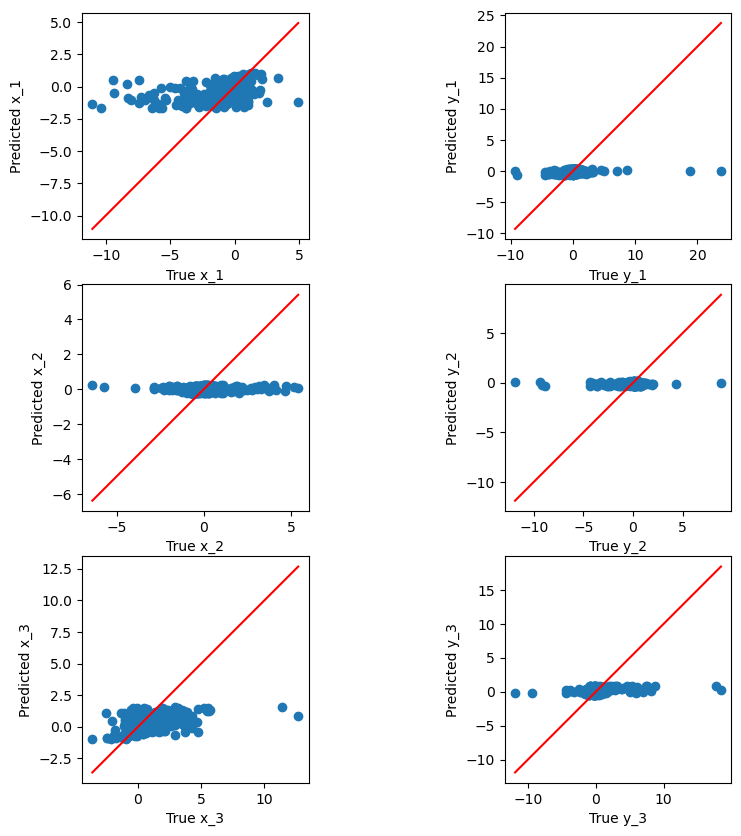

Removed   x0_1  RMSE = 1.4159063657148816


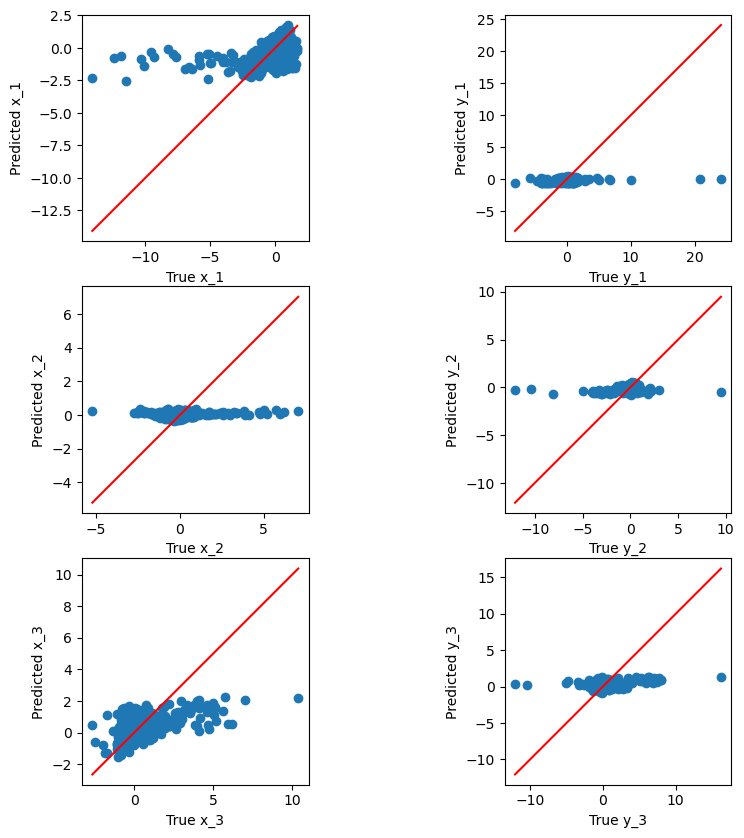

Removed   y0_1  RMSE = 1.4159063657148816


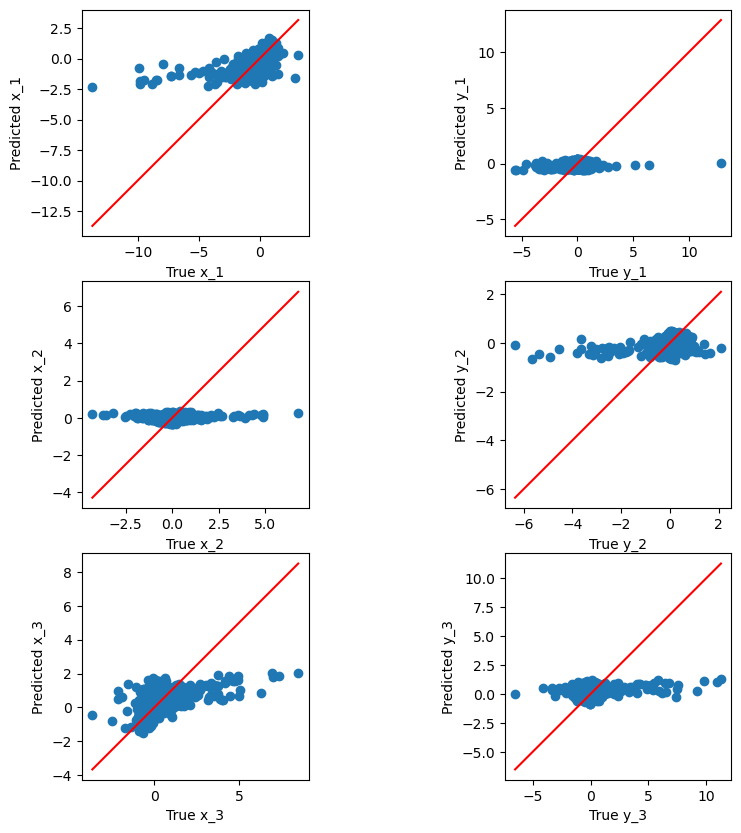

Removed   x0_2  RMSE = 1.4159063657148816


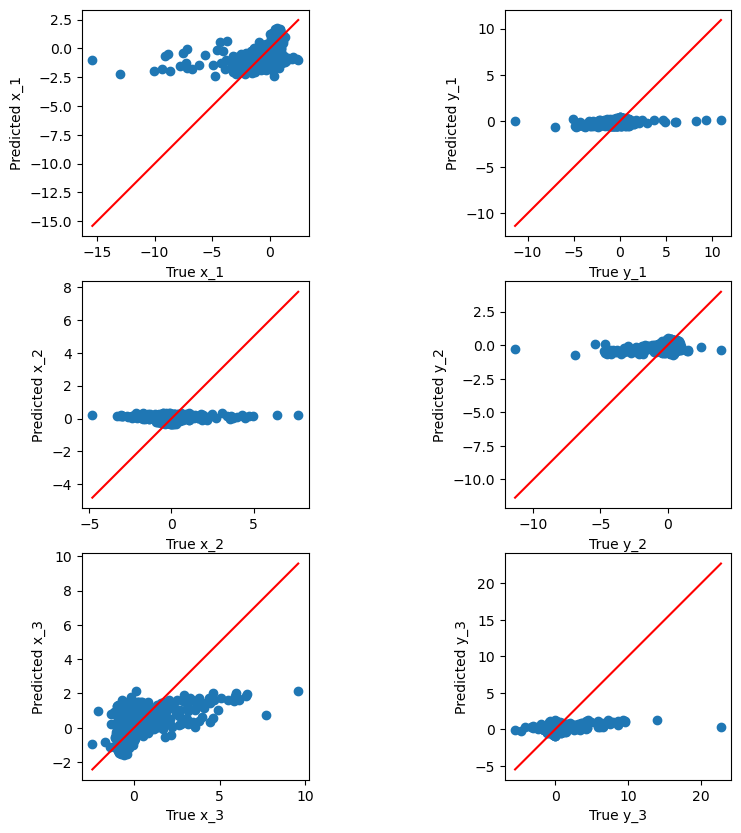

Removed   y0_2  RMSE = 1.4159063657148814


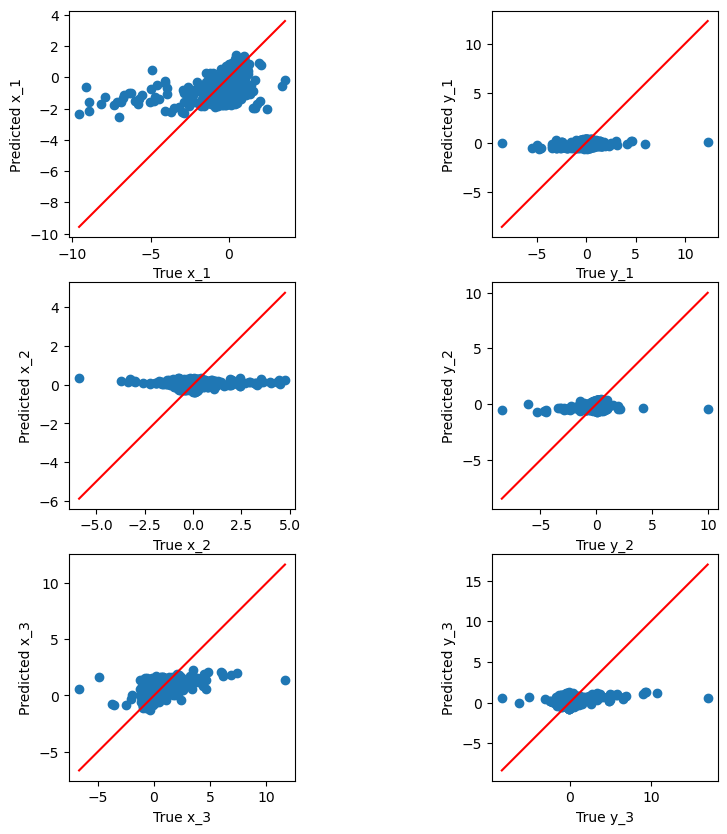

Removed   x0_3  RMSE = 1.4159063657148816


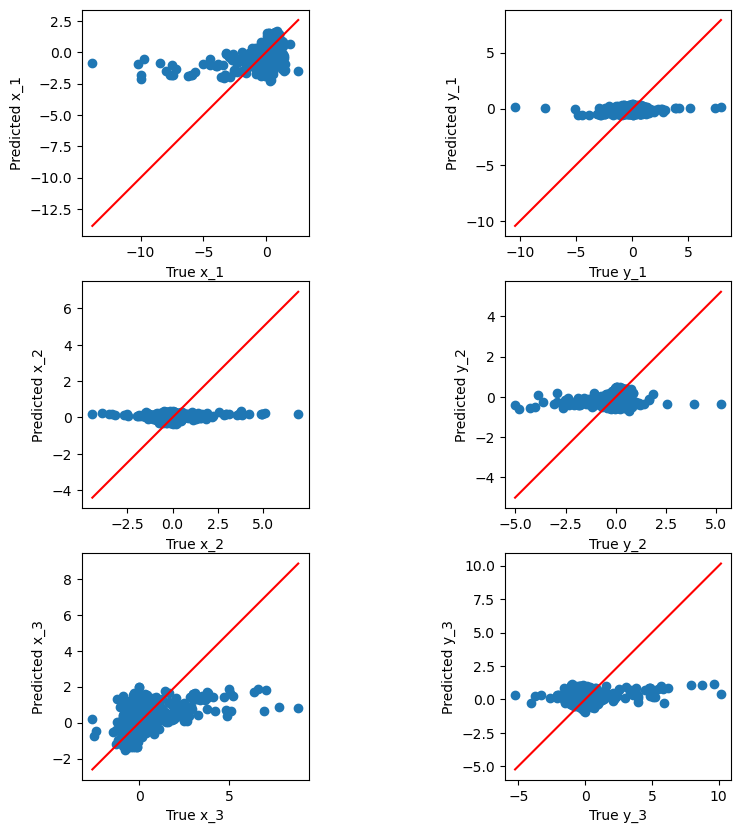

Removed   y0_3  RMSE = 1.4159063657148816


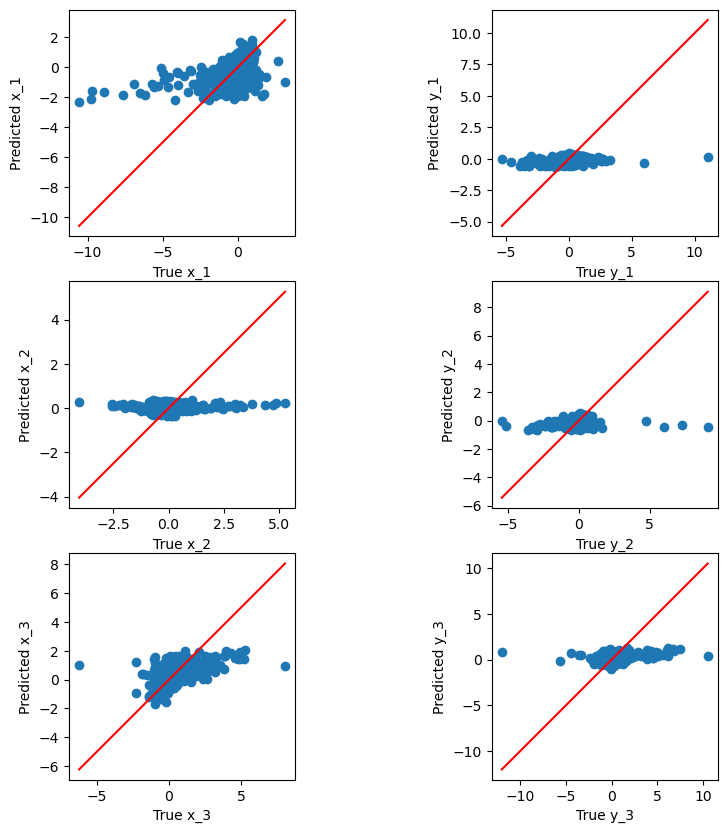

Impact of removing each feature:
  Removed Feature      RMSE
4            y0_2  1.415906
1            x0_1  1.415906
3            x0_2  1.415906
2            y0_1  1.415906
6            y0_3  1.415906
5            x0_3  1.415906
0               t  1.458784


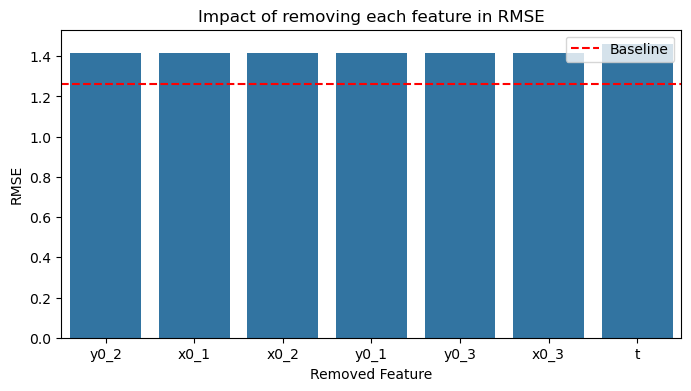

In [ ]:
#We want to correlate the variables "t" (features), and "x_1","y_1",x_2","y_2","x_3" and "y_3" (targets)
#Go get variable t from features
t_features=FEATURES.index("t")
t = X_va[:, t_features] #t is an array contains every value for each "t" (features)

#Join the values from "t" in X_val and x_1","y_1",x_2","y_2","x_3" and "y_3" in y_val
data=np.column_stack((t, y_va)) #Stack o t with y_val
cols=["t"]+TARGETS #Names of columns
df=pd.DataFrame(data, columns=cols) #forms the datatframe

#Pairplot
sns.pairplot(df.sample(200), kind="hist") #Sample of 200 to limit noise 
plt.suptitle("Pairplot with x_i, y_i") 
plt.show()

#Heatmap with correlation
corr=df.corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True)
plt.title("Correlation between variables t, x_i e y_i", fontsize=14),
plt.tight_layout()
plt.show()

#Histograms of individual distributions 
df.hist(bins=30, figsize=(10,6), edgecolor='black')
plt.suptitle("Individual distribution of variables (t, x_i, y_i)", y=1.02)
plt.tight_layout()
plt.show()

#Sort the interactions by the correlation values
corr_pairs=corr.unstack()  #Transform in series and pairs of variables
corr_pairs=corr_pairs.drop_duplicates()  #Removes duplicates (A,B) and (B,A)
sorted_corr=corr_pairs.reindex(corr_pairs.abs().sort_values(ascending=False).index)
print("Correlations by order:\n")
print(sorted_corr)

#Prininting RMSE without any removal 
baseline_rmse=rmse 
print(f" Baseline RMSE (WITHOUT REMOVAL): {baseline_rmse}")

#List do keep results 
results=[]

#Removing each feature
#For each feature in FEATURES
for feat in FEATURES:
    features_temporary = [f for f in FEATURES if f != feat]
    print(f"Removed {feat} → {len(features_temporary)} features left")

for feat in FEATURES:
    features_temporary=[f for f in FEATURES if f!= feat] #List of temporary features, is going to contain every feature minus the one that we want to measure the impact 
    
    #Creates new datasets 
    #tr_df contains every feature from training set ("t", "x_0_1", "y_0_1","x_0_2","y_0_2","x_0_3","y_0_3","x_1","y_1","x_2","y_2","x_3","y_3")
    #tr_df contains every feature from validation set ("t", "x_0_1", "y_0_1","x_0_2","y_0_2","x_0_3","y_0_3","x_1","y_1","x_2","y_2","x_3","y_3")
    X_tr_red = tr_df[features_temporary].values #Selects the "t", "x_0_1", "y_0_1","x_0_2","y_0_2","x_0_3","y_0_3"
    y_tr_red = tr_df[TARGETS].values #Selects "x_1","y_1","x_2","y_2","x_3","y_3"
    X_va_red = va_df[features_temporary].values 
    y_va_red = va_df[TARGETS].values
    
    #New model 
    model_red = make_pipeline(StandardScaler(with_mean=True), LinearRegression()) #Calls the regression pipeline
    model_red.fit(X_tr_red, y_tr_red)#Trains and validates with data with removed feature
    y_hat_red = model_red.predict(X_va_red)  #Previsions for each "x_1","y_1","x_2","y_2","x_3","y_3"
    
    #Calculate RMSE
    rmse_red = np.sqrt(mean_squared_error(y_va_red, y_hat_red))
    
    #Adds to the list the removed feature and the RMSE value for the prevision without the removed feature
    results.append({
        "Removed Feature": feat,
        "RMSE": rmse_red})
    print(f"Removed {feat:>6}  RMSE = {rmse_red}")
    
    #Plot y–ŷ for each removal
    plot_y_yhat(y_va_red, y_hat_red, plot_title=f"remove_{feat}_validation")

#Converts to DataFrame
results_df = pd.DataFrame(results).sort_values("RMSE")
print("Impact of removing each feature:")
print(results_df)

#Comparative plot for slides 
plt.figure(figsize=(8,4))
sns.barplot(data=results_df, x="Removed Feature", y="RMSE") #
plt.axhline(baseline_rmse, color='red', linestyle='--', label='Baseline')
plt.title("Impact of removing each feature in RMSE")
plt.legend()
plt.show()

<h3>Task 3.2 - Evaluation of Variable Reduction</h3>

degree= 1 | feats=    1 | time=  0.00s | RMSE= 1.4754
degree= 2 | feats=    2 | time=  0.01s | RMSE= 1.4739
degree= 3 | feats=    3 | time=  0.01s | RMSE= 1.4734
degree= 4 | feats=    4 | time=  0.01s | RMSE= 1.4736
degree= 5 | feats=    5 | time=  0.01s | RMSE= 1.4729
Best RMSE with reduced Features: 1.4728799746132402


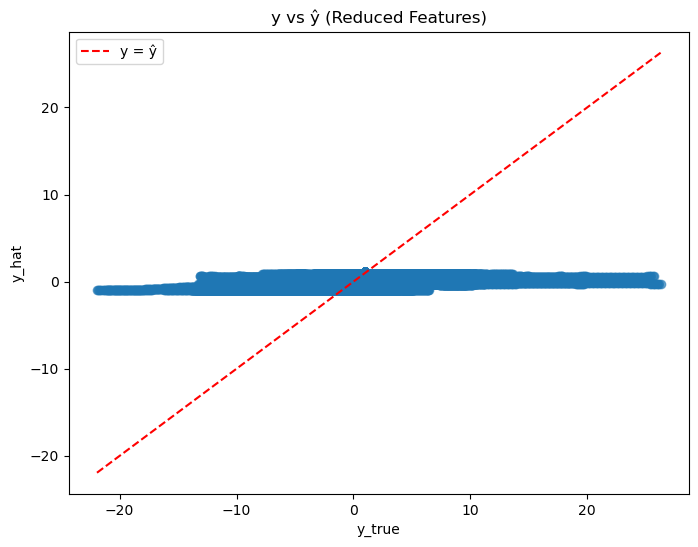

RMSE Task 2: 1.26375059574697
RMSE model with reduced features: 1.4728799746132402
reduced_polynomial_submission.csv created for submission to Kaggle.


In [ ]:
#Creating only datatsets with variable "t" in features (X_tr and X_va)
X_tr_reduced = tr_df[["t"]].values 
X_va_reduced = va_df[["t"]].values
y_tr_reduced = tr_df[TARGETS].values
y_va_reduced = va_df[TARGETS].values

best_model_red, best_rmse_red, logs_red = validate_polynomial(
    X_tr_reduced, y_tr_reduced,
    X_va_reduced, y_va_reduced,
    degrees=range(1, 6),  
    max_features=1500,
    random_state=42,
    use_ridge=False,
    sample_frac=0.05,
    verbose=True
)

print(f"Best RMSE with reduced Features: {best_rmse_red}")

#Y-^y plot for comparing values
y_hat_red = best_model_red.predict(X_va_reduced) #Using prediction with reduced features on validation set

plt.figure(figsize=(8,6))
plt.scatter(y_va_reduced.flatten(), y_hat_red.flatten(), alpha=0.6)
plt.plot([y_va_reduced.min(), y_va_reduced.max()],
         [y_va_reduced.min(), y_va_reduced.max()],
         'r--', label='y = ŷ')
plt.xlabel('y_true')
plt.ylabel('y_hat')
plt.title('y vs ŷ (Reduced Features)')
plt.legend()
plt.show()

#Comparison with Task 2
print(f"RMSE Task 2: {rmse_poly}")
print(f"RMSE model with reduced features: {best_rmse_red}")

#Submission to Kaggle
X_test_reduced = test[["t"]].values
y_test_reduced = best_model_red.predict(X_test_reduced)

reduced = pd.DataFrame({
    "Id": test["Id"].astype(np.int64),
    "x_1": y_test_reduced[:,0], "y_1": y_test_reduced[:,1],
    "x_2": y_test_reduced[:,2], "y_2": y_test_reduced[:,3],
    "x_3": y_test_reduced[:,4], "y_3": y_test_reduced[:,5],
})
submission.to_csv("reduced_polynomial_submission.csv", index=False)
print("reduced_polynomial_submission.csv created for submission to Kaggle.")

<h3>Task 3.3 - Adding Variables</h3>

In [ ]:
#Adding new features
def add_new_features (df):
    eps = 1e-8 #Small value to avoid division by zero
    
    #Inverse of position (1/a)
    df["1/x0_1"]=1/(df["x0_1"]+eps)
    df["1/y0_1"]=1/(df["y0_1"]+eps)
    df["1/x0_2"]=1/(df["x0_2"]+eps)
    df["1/y0_2"]=1/(df["y0_2"]+eps)
    df["1/x0_3"]=1/(df["x0_3"]+eps)
    df["1/y0_3"]=1/(df["y0_3"]+eps)
    
    #Norms (sqrt(a^2))
    df["norm_1"] =np.sqrt(df["x0_1"]**2 + df["y0_1"]**2)
    df["norm_2"] =np.sqrt(df["x0_2"]**2 + df["y0_2"]**2)
    df["norm_3"] =np.sqrt(df["x0_3"]**2 + df["y0_3"]**2)
    
    #Distance between pairs (sqrt(a^2+b^2))
    df["distance_1_2"]=np.sqrt((df["x0_1"]-df["x0_2"])**2 + ((df["y0_1"]-df["y0_2"])**2))
    df["distance_1_3"]=np.sqrt((df["x0_1"]-df["x0_3"])**2 + ((df["y0_1"]-df["y0_3"])**2))
    df["distance_2_3"]=np.sqrt((df["x0_2"]-df["x0_3"])**2 + ((df["y0_2"]-df["y0_3"])**2))

    #Geometric center
    df["distance_of_x"]=(df["x0_1"] + df["x0_2"] + df["x0_3"]) / 3
    df["distance_of_y"]=(df["y0_1"] + df["y0_2"] + df["y0_3"]) / 3

    return df

#Apply to train and validation sets
train_new_features=add_new_features(tr_df)
validate_new_features=add_new_features(va_df)

#Updating the features set
NEW_FEATURES= FEATURES + [
    "1/x0_1","1/y0_1","1/x0_2","1/y0_2","1/x0_3","1/y0_3",
    "norm_1","norm_2","norm_3",
    "distance_1_2","distance_1_3","distance_2_3",
    "distance_of_x","distance_of_y"]

#Creating the new datasets
X_tr_new_features=train_new_features[NEW_FEATURES].values
y_tr_new_features=train_new_features[TARGETS].values
X_va_new_features=validate_new_features[NEW_FEATURES].values
y_va_new_features=validate_new_features[TARGETS].values

#Training baseline model with new added features
baseline_new_features = make_pipeline(StandardScaler(with_mean=True), LinearRegression())
baseline_new_features.fit(X_tr_new_features, y_tr_new_features)
y_hat_new_features = baseline_new_features.predict(X_va_new_features)  #Prevision in validation datatset

#Print the results
rmse_new_features = np.sqrt(mean_squared_error(y_va_new_features, y_hat_new_features))
print(f"Baseline RMSE (validation split) with new features: {rmse_new_features}")
print(f"RMSE Baseline original: {rmse_baseline}")

Baseline RMSE (validation split) with new features: 1.3651912487572309
RMSE Baseline original: 1.4159063657148816


<h3>Task 3.4 - Evaluation of Variable Augmentation</h3>

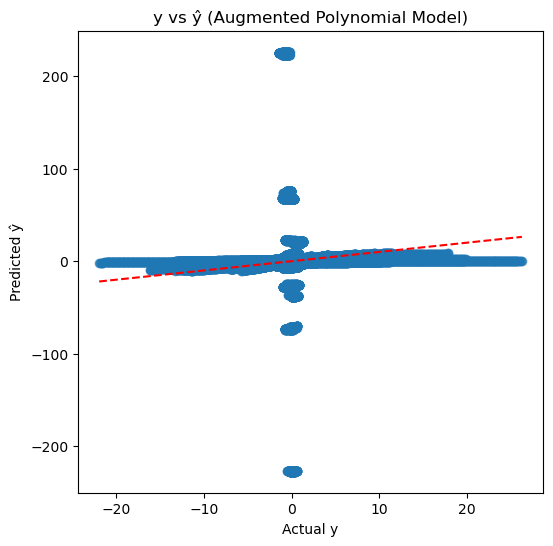

Polynomial RMSE (validation) with augmented features: 5.919037712970602
Polynomial RMSE (validation) without augmented features: 1.26375059574697


In [ ]:
def add_new_features_augmentation (X):
    df=pd.DataFrame(X, columns=FEATURES)
    df_augmented=add_new_features(df)
    return df_augmented.values

#Using ColumnTransformer and FunctionTransformer to add new features 
#Augmenter applies the function add_new_features_augmentation to the columns in FEATURES
augmenter=FunctionTransformer(add_new_features_augmentation, validate=False)

#Applies the augmenter to the columns in FEATURES and leaves the rest of the columns unchanged
preprocessor=ColumnTransformer(
    transformers=[
        ('augment', augmenter, FEATURES)],
    remainder="passthrough")

#Pipeline with augmented features
#Transforms X_tr in X_aumented with the new features
polynomial_augmentation = make_pipeline(
    preprocessor,
    PolynomialFeatures(degree=3, include_bias=False), #Using only the best degree (should be 5)
    StandardScaler(with_mean=True),
    pick_regressor(use_ridge=True, ridge_alphas=(0.01, 0.1, 1.0, 10.0, 100.0))
)

X_tr = pd.DataFrame(X_tr, columns=FEATURES)
X_va = pd.DataFrame(X_va, columns=FEATURES)
X_test = pd.DataFrame(X_test, columns=FEATURES)
test_ids = test["Id"].astype(np.int64)

# Training the model with augmented features
polynomial_augmentation.fit(X_tr, y_tr)
y_hat_augmented=polynomial_augmentation.predict(X_va)  #Prevision

#y–ŷ plot for comparing values
plt.figure(figsize=(6,6))
plt.scatter(y_va, y_hat_augmented, alpha=0.6)
plt.plot([y_va.min(), y_va.max()], [y_va.min(), y_va.max()], 'r--')
plt.xlabel("Actual y")
plt.ylabel("Predicted ŷ")
plt.title("y vs ŷ (Augmented Polynomial Model)")
plt.show()

#Print the results
rmse_augmented = np.sqrt(mean_squared_error(y_va, y_hat_augmented))
print(f"Polynomial RMSE (validation) with augmented features: {rmse_augmented}")
print(f"Polynomial RMSE (validation) without augmented features: {rmse_poly}")

#Exportation to Kaggle
X_test_augmentation = test[["t"]].values
y_test = polynomial_augmentation.predict(X_test)

#Saving submission in required format
augmentation = pd.DataFrame({
    "Id": test["Id"].astype(np.int64),
    "x_1": y_test[:,0], "y_1": y_test[:,1],
    "x_2": y_test[:,2], "y_2": y_test[:,3],
    "x_3": y_test[:,4], "y_3": y_test[:,5],
})


augmentation.to_csv("../outputs/csv/augmented_polynomial_submission.csv", index=False)

<h3>Task 4: Nonparametric Model — the k-Nearest Neighbors Regressor</h3>

<h3>Task 4.1 Development</h3>

In [ ]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def run_knn_sweep(Xtr, ytr, Xva, yva, k_min=1, k_max=15):
    """
    Varre k=[k_min..k_max] com weights='distance' e p=2 (euclidiana).
    Devolve (results_df_ordenado, best_k, best_model).
    """
    rows = []
    best = (None, np.inf, None)  # (k, rmse, model)

    for k in range(k_min, k_max+1):
        t0 = time.time()
        model = make_pipeline(StandardScaler(), KNeighborsRegressor(n_neighbors=k, weights="distance", p=2, n_jobs=-1))
        model.fit(Xtr, ytr)
        fit_t = time.time() - t0

        t1 = time.time()
        yhat = model.predict(Xva)
        pred_t = time.time() - t1

        err = rmse(yva, yhat)
        rows.append([k, fit_t, pred_t, err])

        if err < best[1]:
            best = (k, err, model)

    df = pd.DataFrame(rows, columns=["k", "train_time_s", "pred_time_s", "rmse"]).sort_values("rmse").reset_index(drop=True)
    return df, best[0], best[2]

# --------- Construir o catálogo de feature sets disponíveis ---------
FEATURE_SETS = {"baseline": (X_tr, X_va)}  # baseline é obrigatório

# adiciona reduzido/augmentado se existirem
if "X_tr_reduced" in globals() and "X_va_reduced" in globals():
    FEATURE_SETS["reduced"] = (X_tr_reduced, X_va_reduced)

if "X_tr_aug" in globals() and "X_va_aug" in globals():
    FEATURE_SETS["augmented"] = (X_tr_aug, X_va_aug)

# --------- Correr avaliação por feature set ---------
summary_rows = []
BEST_MODELS_4p1 = {}  # guarda o melhor modelo de cada set para usar na 4.2

for name, (Xtr_set, Xva_set) in FEATURE_SETS.items():
    print(f"\n=== Feature set: {name} ===")
    df, best_k, best_model = run_knn_sweep(Xtr_set, y_tr, Xva_set, y_va, k_min=1, k_max=15)
    print(df.head(10))  # primeiras linhas ordenadas por melhor RMSE

    best_row = df.iloc[0]  # menor RMSE
    summary_rows.append({
        "feature_set": name,
        "best_k": int(best_k),
        "best_rmse": float(best_row["rmse"]),
        "best_train_time_s": float(best_row["train_time_s"]),
        "best_pred_time_s": float(best_row["pred_time_s"]),
        "weights": "distance",
        "p": 2
    })
    BEST_MODELS_4p1[name] = {"k": int(best_k), "model": best_model}

# --------- Tabela-resumo final (para os slides) ---------
summary_df = pd.DataFrame(summary_rows).sort_values("best_rmse").reset_index(False)
print("\n=== Resumo kNN por feature set (menor RMSE) ===")
print(summary_df)


=== Feature set: baseline ===
    k  train_time_s  pred_time_s      rmse
0  15      0.680313     0.392592  1.023063
1  14      0.702538     0.490284  1.032957
2  13      0.675586     0.362003  1.045802
3  12      0.676296     0.470137  1.050297
4  11      0.674923     0.333922  1.060416
5  10      0.698037     0.449315  1.073039
6   9      0.692680     0.314470  1.084845
7   8      0.694951     0.346220  1.087872
8   7      0.674877     0.326021  1.093302
9   6      0.678984     0.259100  1.100462

=== Feature set: reduced ===
    k  train_time_s  pred_time_s      rmse
0  15      0.164771     2.810585  1.505071
1  14      0.166204     3.777990  1.512616
2  13      0.165050     2.761784  1.522331
3  12      0.168492     3.764124  1.533481
4  11      0.168907     2.784270  1.546685
5   7      0.164332     3.723217  1.551678
6  10      0.167562     2.714510  1.560382
7   6      0.163907     2.738369  1.568454
8   9      0.168933     2.709976  1.576966
9   5      0.165020     2.641622  1.

<h3>Task 4.2 Evaluation</h3>

In [ ]:
# -------- SPEED PATCH para a 4.2 --------
import numpy as np
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

LABELS = ('x_1','y_1','x_2','y_2','x_3','y_3')

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def rmse_per_target(y_true, y_pred, labels=LABELS):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    return pd.Series([rmse(y_true[:,i], y_pred[:,i]) for i in range(y_true.shape[1])], index=labels)

def predict_in_batches(model, X, batch_size=200_000):
    """Prevê X em blocos para evitar picos de RAM e travamentos."""
    X = np.asarray(X, dtype=np.float32)
    n, out_dim = X.shape[0], 6
    out = np.empty((n, out_dim), dtype=np.float32)
    for i in range(0, n, batch_size):
        j = min(i + batch_size, n)
        out[i:j] = model.predict(X[i:j]).astype(np.float32, copy=False)
    return out

# 1) Baseline (rápido)
baseline = make_pipeline(StandardScaler(with_mean=True), LinearRegression())
baseline.fit(X_tr.astype(np.float32), y_tr.astype(np.float32))
y_hat_base = baseline.predict(X_va.astype(np.float32))

# 2) Polynomial (Task 2) — usa o pipeline já escolhido na T2 *se existir*
y_hat_poly = None
if 'chosen_model' in globals():
    # só refit no subset de validação (rápido); o chosen_model já tem a config certa
    chosen_model.fit(X_tr.astype(np.float32), y_tr.astype(np.float32))
    y_hat_poly = chosen_model.predict(X_va.astype(np.float32))

# 3) Feature Engineering (Task 3) — *evita* refit pesado se não precisares agora
y_hat_feat = None
if 'polynomial_augmentation' in globals():
    # cuidado: isto pode ser pesado; se estiver a demorar, comenta estas 3 linhas
    polynomial_augmentation.fit(pd.DataFrame(X_tr, columns=FEATURES), y_tr)
    y_hat_feat = polynomial_augmentation.predict(pd.DataFrame(X_va, columns=FEATURES))

# 4) kNN (Task 4) — usa o melhor k da 4.1
best_k = int(summary_df.loc[summary_df['best_rmse'].idxmin(), 'best_k'])
knn = make_pipeline(
    StandardScaler(with_mean=True),
    KNeighborsRegressor(n_neighbors=best_k, weights="distance", p=2, n_jobs=-1)
)
knn.fit(X_tr.astype(np.float32), y_tr.astype(np.float32))
y_hat_knn = knn.predict(X_va.astype(np.float32))

# 5) Comparação de RMSE (validação)
models = {"Baseline (LinearRegression)": y_hat_base, f"kNN (Task 4, k={best_k})": y_hat_knn}
if y_hat_poly is not None: models["Polynomial (Task 2)"] = y_hat_poly
if y_hat_feat is not None: models["Feature Eng. (Task 3)"] = y_hat_feat

rows = []
for name, yhat in models.items():
    row = {"Model": name, "RMSE_total": rmse(y_va, yhat)}
    row.update({f"RMSE_{lbl}": v for lbl, v in rmse_per_target(y_va, yhat).items()})
    rows.append(row)
eval_df = pd.DataFrame(rows).sort_values("RMSE_total").reset_index(drop=True)
print("== RMSE comparison (val) ==")
print(eval_df)

# 6) Submissão Kaggle com o kNN vencedor — PREVISÃO EM BLOCOS
X_trva = np.vstack([X_tr, X_va]).astype(np.float32)
y_trva = np.vstack([y_tr, y_va]).astype(np.float32)

final_knn = make_pipeline(
    StandardScaler(with_mean=True),
    KNeighborsRegressor(n_neighbors=best_k, weights="distance", p=2, n_jobs=-1)
)
final_knn.fit(X_trva, y_trva)

# garantir float32 e prever aos blocos (ex.: 200k)
X_test_np = np.asarray(X_test, dtype=np.float32)
y_test_pred = predict_in_batches(final_knn, X_test_np, batch_size=200_000)

knn_submission = pd.DataFrame({
    "Id": test["Id"].astype(np.int64),
    "x_1": y_test_pred[:,0], "y_1": y_test_pred[:,1],
    "x_2": y_test_pred[:,2], "y_2": y_test_pred[:,3],
    "x_3": y_test_pred[:,4], "y_3": y_test_pred[:,5],
})
knn_submission.to_csv("../outputs/csv/knn_submission.csv", index=False)
print("Saved: knn_submission.csv (batched prediction)")


== RMSE comparison (val) ==
                         Model  RMSE_total  RMSE_x_1  RMSE_y_1  RMSE_x_2  \
0           kNN (Task 4, k=15)    1.023068  1.081399  1.191006  0.748375   
1          Polynomial (Task 2)    1.260293  1.460082  1.328652  1.044247   
2  Baseline (LinearRegression)    1.415912  1.666677  1.417991  1.114458   
3        Feature Eng. (Task 3)    5.919038  1.659728  3.443187  9.284628   

   RMSE_y_2  RMSE_x_3  RMSE_y_3  
0  0.785684  0.940546  1.276754  
1  0.968489  1.040711  1.587884  
2  1.057683  1.264511  1.811251  
3  3.437449  9.257252  3.447135  
Saved: knn_submission.csv (batched prediction)
